<a href="https://colab.research.google.com/github/sivat14/Assignment_1_DL/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#   MULTI-LABEL TEXT CLASSIFICATION (ARXIV ABSTRACTS)

!pip install gensim transformers datasets torchtext scikit-learn matplotlib --quiet

import ast
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, hamming_loss, precision_recall_curve, auc
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec
import torch.nn.functional as F

from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.7 MB/s eta 0:00:00
Device: cuda


In [ ]:
# 1. LOAD DATA
df = pd.read_csv("/content/arxiv_data.csv", on_bad_lines='skip', engine='python')

# Parse list-style labels
df["terms"] = df["terms"].apply(lambda x: ast.literal_eval(x))

texts = df["summaries"].astype(str).tolist()
labels = df["terms"].tolist()

In [ ]:
# 2. MULTI-LABEL BINARIZATION (Top 50 categories)
all_labels_flat = [lab for sublist in labels for lab in sublist]
top50 = pd.Series(all_labels_flat).value_counts().head(50).index.tolist()

labels_filtered = [[l for l in lab_list if l in top50] for lab_list in labels]
mlb = MultiLabelBinarizer(classes=top50)
Y = mlb.fit_transform(labels_filtered)

# Train/Val/Test
X_train, X_temp, y_train, y_temp = train_test_split(texts, Y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# 3. SIMPLE DATASET CLASS
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer_fn=None):
        self.texts = texts
        self.labels = labels
        self.tokenizer_fn = tokenizer_fn

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = self.texts[idx]
        y = self.labels[idx] if self.labels is not None else None
        if self.tokenizer_fn:
            return self.tokenizer_fn(x), torch.tensor(y, dtype=torch.float)
        return x, torch.tensor(y, dtype=torch.float)


In [ ]:
# 4. TRAINING LOOP (GENERIC)
def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                epoch_val_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))
        val_losses.append(epoch_val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


def evaluate_model(model, test_loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb)
            out = torch.sigmoid(out).cpu().numpy()
            preds.append(out)
            trues.append(yb.numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)

    metrics = {
        "micro_f1": f1_score(trues, preds > 0.5, average="micro"),
        "macro_f1": f1_score(trues, preds > 0.5, average="macro"),
        "micro_precision": precision_score(trues, preds > 0.5, average="micro"),
        "micro_recall": recall_score(trues, preds > 0.5, average="micro"),
        "roc_auc_micro": roc_auc_score(trues, preds, average="micro"),
        "hamming_loss": hamming_loss(trues, preds > 0.5),
    }
    return metrics, preds, trues


def plot_loss(train, val, title):
    plt.figure(figsize=(6,4))
    plt.plot(train, label="Train")
    plt.plot(val, label="Val")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def plot_pr_curve(preds, trues, title):
    precision, recall, _ = precision_recall_curve(trues.ravel(), preds.ravel())
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision)
    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()


In [ ]:
# FFN Model
class FFN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)



===== Training Word2Vec Model =====
Epoch 1/5 | Train Loss: 0.0720 | Val Loss: 0.0581
Epoch 2/5 | Train Loss: 0.0577 | Val Loss: 0.0561
Epoch 3/5 | Train Loss: 0.0562 | Val Loss: 0.0555
Epoch 4/5 | Train Loss: 0.0553 | Val Loss: 0.0553
Epoch 5/5 | Train Loss: 0.0546 | Val Loss: 0.0548


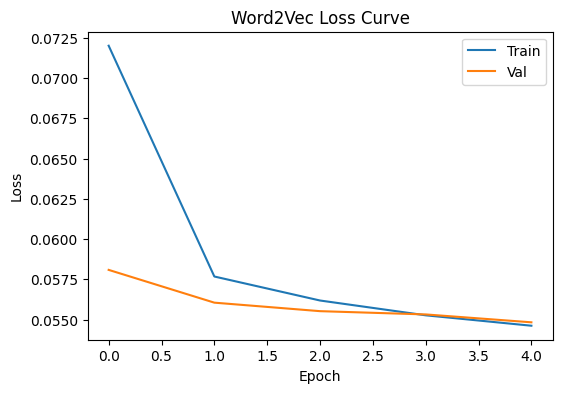

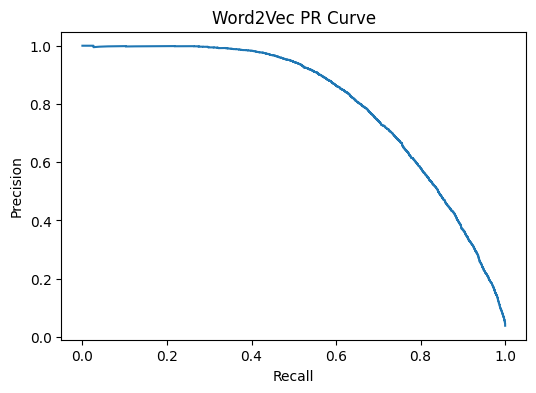

In [ ]:
# 5. WORD2VEC EMBEDDINGS
tokenized = [t.split() for t in X_train]
w2v = Word2Vec(tokenized, vector_size=100, window=5, min_count=2, workers=4)
w2v_vectors = w2v.wv.key_to_index

def embed_w2v(text):
    tokens = text.split()
    vecs = [w2v.wv[w] for w in tokens if w in w2v_vectors]
    if len(vecs)==0:
        return torch.zeros(100)
    return torch.tensor(np.mean(vecs, axis=0), dtype=torch.float)

class EmbeddingDataset(Dataset):
    def __init__(self, texts, labels, embed_fn):
        self.texts, self.labels, self.embed_fn = texts, labels, embed_fn

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        return self.embed_fn(self.texts[idx]), torch.tensor(self.labels[idx], dtype=torch.float)

train_ds_w2v = EmbeddingDataset(X_train, y_train, embed_w2v)
val_ds_w2v   = EmbeddingDataset(X_val, y_val, embed_w2v)
test_ds_w2v  = EmbeddingDataset(X_test, y_test, embed_w2v)

train_dl_w2v = DataLoader(train_ds_w2v, batch_size=32, shuffle=True)
val_dl_w2v   = DataLoader(val_ds_w2v, batch_size=32)
test_dl_w2v  = DataLoader(test_ds_w2v, batch_size=32)

model_w2v = FFN(100, len(top50)).to(device)

print("\n===== Training Word2Vec Model =====")
tr_w2v, val_w2v = train_model(model_w2v, train_dl_w2v, val_dl_w2v, epochs=5)
metrics_w2v, p_w2v, t_w2v = evaluate_model(model_w2v, test_dl_w2v)

plot_loss(tr_w2v, val_w2v, "Word2Vec Loss Curve")
plot_pr_curve(p_w2v, t_w2v, "Word2Vec PR Curve")




===== Training GloVe Model =====
Epoch 1/5 | Train Loss: 0.0876 | Val Loss: 0.0711
Epoch 2/5 | Train Loss: 0.0706 | Val Loss: 0.0681
Epoch 3/5 | Train Loss: 0.0685 | Val Loss: 0.0665
Epoch 4/5 | Train Loss: 0.0669 | Val Loss: 0.0648
Epoch 5/5 | Train Loss: 0.0656 | Val Loss: 0.0643


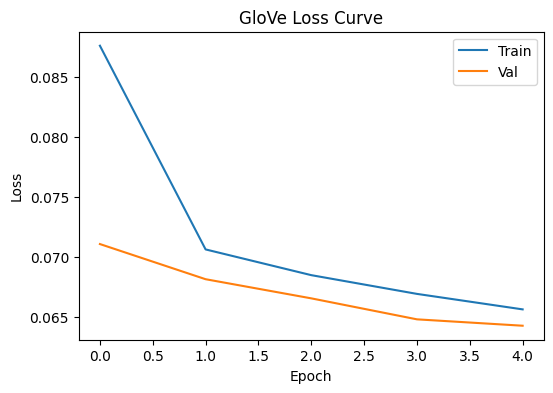

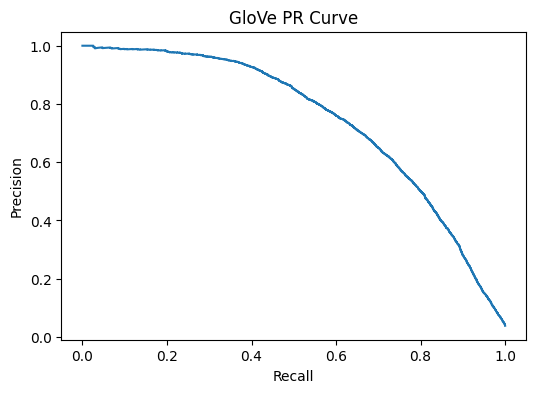

In [ ]:
# 6. GLOVE EMBEDDINGS (300d)

glove_path = "/content/glove.6B.300d.txt"
glove_model = {}
with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        w, *vec = line.split()
        try:
            glove_model[w] = np.asarray(vec, dtype=float)
        except ValueError:
            # Skip lines with malformed vectors (e.g., non-float characters)
            continue

def embed_glove(text):
    tokens = text.split()
    vecs = [glove_model[w] for w in tokens if w in glove_model]
    if len(vecs)==0:
        return torch.zeros(100)
    return torch.tensor(np.mean(vecs, axis=0), dtype=torch.float)

train_ds_gv = EmbeddingDataset(X_train, y_train, embed_glove)
val_ds_gv   = EmbeddingDataset(X_val, y_val, embed_glove)
test_ds_gv  = EmbeddingDataset(X_test, y_test, embed_glove)

train_dl_gv = DataLoader(train_ds_gv, batch_size=32, shuffle=True)
val_dl_gv   = DataLoader(val_ds_gv, batch_size=32)
test_dl_gv  = DataLoader(test_ds_gv, batch_size=32)

# The FFN model for GloVe should match the embedding dimension. If using glove.6B.300d.txt
# the input_dim should be 300, not 100. Correcting this.
model_gv = FFN(300, len(top50)).to(device)

print("\n===== Training GloVe Model =====")
tr_gv, val_gv = train_model(model_gv, train_dl_gv, val_dl_gv, epochs=5)
metrics_gv, p_gv, t_gv = evaluate_model(model_gv, test_dl_gv)

plot_loss(tr_gv, val_gv, "GloVe Loss Curve")
plot_pr_curve(p_gv, t_gv, "GloVe PR Curve")


===== Training FastText Model ====
Epoch 1/5 | Train Loss: 0.0892 | Val Loss: 0.0696
Epoch 2/5 | Train Loss: 0.0680 | Val Loss: 0.0656
Epoch 3/5 | Train Loss: 0.0657 | Val Loss: 0.0642
Epoch 4/5 | Train Loss: 0.0642 | Val Loss: 0.0625
Epoch 5/5 | Train Loss: 0.0628 | Val Loss: 0.0612


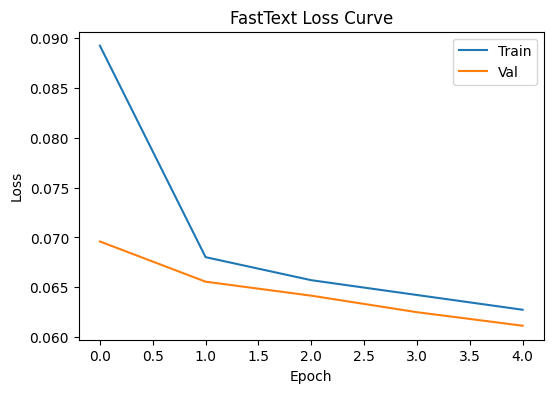

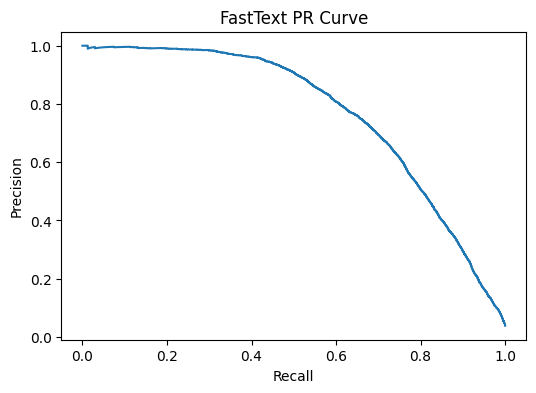

In [ ]:
# 7. FASTTEXT (PRETRAINED)
!wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec

fasttext_model = {}
with open("wiki.simple.vec", "r", encoding="utf8", errors="ignore") as f:
    next(f)
    for line in f:
        w, *vec = line.rstrip().split()
        try:
            fasttext_model[w] = np.asarray(vec, dtype=float)
        except ValueError:
            # Skip lines with malformed vectors (e.g., non-float characters)
            continue

def embed_ft(text):
    tokens = text.split()
    vecs = [fasttext_model[w] for w in tokens if w in fasttext_model]
    if len(vecs)==0:
        return torch.zeros(300)
    return torch.tensor(np.mean(vecs, axis=0), dtype=torch.float)

train_ds_ft = EmbeddingDataset(X_train, y_train, embed_ft)
val_ds_ft   = EmbeddingDataset(X_val, y_val, embed_ft)
test_ds_ft  = EmbeddingDataset(X_test, y_test, embed_ft)

train_dl_ft = DataLoader(train_ds_ft, batch_size=32, shuffle=True)
val_dl_ft   = DataLoader(val_ds_ft, batch_size=32)
test_dl_ft  = DataLoader(test_ds_ft, batch_size=32)

model_ft = FFN(300, len(top50)).to(device)

print("\n===== Training FastText Model ====")
tr_ft, val_ft = train_model(model_ft, train_dl_ft, val_dl_ft, epochs=5)
metrics_ft, p_ft, t_ft = evaluate_model(model_ft, test_dl_ft)

plot_loss(tr_ft, val_ft, "FastText Loss Curve")
plot_pr_curve(p_ft, t_ft, "FastText PR Curve")

In [ ]:
from sentence_transformers import SentenceTransformer
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, hamming_loss
import numpy as np

# Config
SBERT_MODEL = "all-MiniLM-L6-v2"
BATCH_EMBED = 64
TRAIN_BS = 32
EPOCHS = 5
LR = 1e-3

# 1) Compute SBERT embeddings (one-time)
sbert = SentenceTransformer(SBERT_MODEL, device=device)
print("Computing SBERT embeddings (train/val/test)...")
X_tr_emb = sbert.encode(list(X_train), batch_size=BATCH_EMBED, show_progress_bar=True, convert_to_numpy=True).astype(np.float32)
X_val_emb = sbert.encode(list(X_val),   batch_size=BATCH_EMBED, show_progress_bar=True, convert_to_numpy=True).astype(np.float32)
X_test_emb= sbert.encode(list(X_test),  batch_size=BATCH_EMBED, show_progress_bar=True, convert_to_numpy=True).astype(np.float32)
print("Done. Shapes:", X_tr_emb.shape, X_val_emb.shape, X_test_emb.shape)

train_ds = TensorDataset(torch.from_numpy(X_tr_emb), torch.from_numpy(np.array(y_train)).float())
val_ds   = TensorDataset(torch.from_numpy(X_val_emb), torch.from_numpy(np.array(y_val)).float())
test_ds  = TensorDataset(torch.from_numpy(X_test_emb), torch.from_numpy(np.array(y_test)).float())

train_loader = DataLoader(train_ds, batch_size=TRAIN_BS, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=TRAIN_BS, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=TRAIN_BS, shuffle=False)

input_dim = X_tr_emb.shape[1]
output_dim = np.array(y_train).shape[1] if hasattr(y_train, "shape") else len(y_train[0])
model = FFN(input_dim, output_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCEWithLogitsLoss()

best_val_micro = -1.0
best_state = None
train_losses, val_losses = [], []

# 4) Train loop
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)                     # your FFN returns logits
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    avg_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_running = 0.0
    all_probs, all_y = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            val_running += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_y.append(yb.cpu().numpy())
    avg_val_loss = val_running / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    probs_val = np.vstack(all_probs)
    y_val_np = np.vstack(all_y)
    preds_val = (probs_val >= 0.5).astype(int)

    micro = f1_score(y_val_np, preds_val, average="micro", zero_division=0)
    macro = f1_score(y_val_np, preds_val, average="macro", zero_division=0)
    prec  = precision_score(y_val_np, preds_val, average="micro", zero_division=0)
    rec   = recall_score(y_val_np, preds_val, average="micro", zero_division=0)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
          f"| Val micro-F1: {micro:.4f} | Val macro-F1: {macro:.4f}")

    if micro > best_val_micro:
        best_val_micro = micro
        best_state = model.state_dict()

# restore best model
if best_state is not None:
    model.load_state_dict(best_state)

# 5) Test evaluation
model.eval()
probs_all, trues_all = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        probs_all.append(probs)
        trues_all.append(yb.numpy())

probs_all = np.vstack(probs_all)
trues_all = np.vstack(trues_all)
preds_test = (probs_all >= 0.5).astype(int)

metrics = {
    "micro_f1": f1_score(trues_all, preds_test, average="micro", zero_division=0),
    "macro_f1": f1_score(trues_all, preds_test, average="macro", zero_division=0),
    "precision_micro": precision_score(trues_all, preds_test, average="micro", zero_division=0),
    "recall_micro": recall_score(trues_all, preds_test, average="micro", zero_division=0),
    "hamming_loss": hamming_loss(trues_all, preds_test)
}
try:
    metrics["roc_auc_micro"] = roc_auc_score(trues_all, probs_all, average="micro")
except Exception:
    metrics["roc_auc_micro"] = float("nan")

print("Test metrics (FFN on SBERT embeddings):", metrics)



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing SBERT embeddings (train/val/test)...


Batches:   0%|          | 0/485 [00:00<?, ?it/s]

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Done. Shapes: (31008, 384) (3876, 384) (3877, 384)
Epoch 1 | Train Loss: 0.0763 | Val Loss: 0.0533 | Val micro-F1: 0.7329 | Val macro-F1: 0.0699
Epoch 2 | Train Loss: 0.0523 | Val Loss: 0.0501 | Val micro-F1: 0.7365 | Val macro-F1: 0.0881
Epoch 3 | Train Loss: 0.0498 | Val Loss: 0.0488 | Val micro-F1: 0.7391 | Val macro-F1: 0.1072
Epoch 4 | Train Loss: 0.0483 | Val Loss: 0.0489 | Val micro-F1: 0.7432 | Val macro-F1: 0.1172
Epoch 5 | Train Loss: 0.0472 | Val Loss: 0.0477 | Val micro-F1: 0.7396 | Val macro-F1: 0.1269
Test metrics (FFN on SBERT embeddings): {'micro_f1': 0.7316582914572864, 'macro_f1': 0.13805008834220078, 'precision_micro': 0.8665079655740707, 'recall_micro': 0.6331281776826331, 'hamming_loss': 0.01790559711116843, 'roc_auc_micro': np.float64(0.9845753832843357)}


In [ ]:
# 9. FINAL COMPARISON TABLE
results = {
    "Word2Vec": metrics_w2v,
    "GloVe": metrics_gv,
    "FastText": metrics_ft,
    "BERT": metrics
}

print("\n===== FINAL MODEL COMPARISON =====")
df_results = pd.DataFrame(results).T
df_results



===== FINAL MODEL COMPARISON =====


,micro_f1,macro_f1,micro_precision,micro_recall,roc_auc_micro,hamming_loss,precision_micro,recall_micro
Word2Vec,0.712128,0.066379,0.851452,0.611988,0.975976,0.019077,NaN,NaN
GloVe,0.665495,0.046166,0.776213,0.582419,0.962346,0.022574,NaN,NaN
FastText,0.686817,0.047967,0.816172,0.592855,0.966306,0.020846,NaN,NaN
BERT,0.731658,0.138050,NaN,NaN,0.984575,0.017906,0.866508,0.633128
